In [1]:
import os
import tobac

from glob import glob
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import scipy
import rioxarray
import geopandas as gpd
import folium
from scipy import ndimage
from folium.plugins import Draw

import pyresample
from pyresample.geometry import SwathDefinition

from shapely.geometry import Polygon
from scipy.stats.mstats import trimmed_std, trimmed_mean

import string
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
import geopandas as gpd
import contextily as cx

In [2]:
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from shapely.geometry.point import Point


In [3]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [4]:
data_dir = '../data/ch4_cases/Azerbaijan/OSM/'
ds_l2 = xr.open_dataset(glob(data_dir+'EMIT_L2B_*.nc')[0], decode_coords='all')
dxy = ds_l2.x.diff('x')[0].values  # data resolution; Unit: m

## Methane enhancement overview

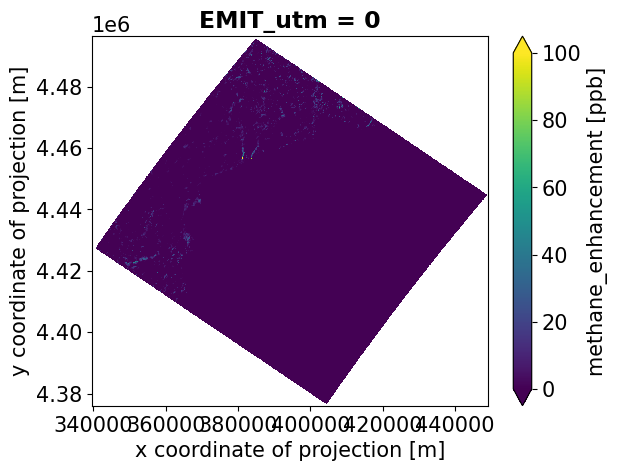

In [5]:
ds_l2['ch4_comb_denoise'].plot(vmin=0, vmax=100)

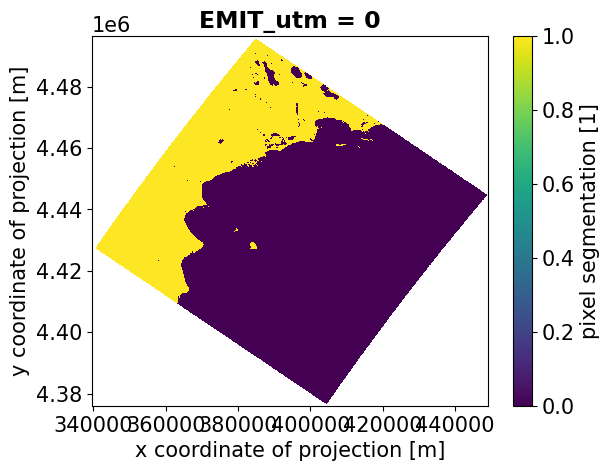

In [6]:
ds_l2['segmentation'].plot()

## Feature detection

In [7]:
for varname in ['ch4_comb', 'ch4_comb_denoise']:
    # remove attrs for iris
    ds_l2[varname].attrs['standard_name'] = ''

    time_da = pd.date_range(start=ds_l2[varname].attrs['start_time'], periods=1, freq='D').to_numpy()

    ds_l2[varname] = ds_l2[varname].expand_dims(time=time_da)

In [8]:
def get_feature_mask(ds, varname='ch4_comb_denoise',
                sigma_threshold=1, n_min_threshold=5):
    dxy = abs(ds[varname].y.diff('y')[0])

    # get the segmentation values
    segmentation = pd.unique(ds['segmentation'].data.flatten())
    segmentation = segmentation[~np.isnan(segmentation)]

    feature_list = []
    mask_list = []

    mask_max = 0
    detect_mask = False

    for seg in segmentation:
        print('seg', seg)
        # loop segmentation (0: ocean, >=1: land)
        seg_mask = ds['segmentation']==seg
        ch4_mask = ds[varname].where(seg_mask)
        # trim_mean = ch4_mask.mean()
        # trim_std = ch4_mask.std()
        trim_mean = trimmed_mean(ch4_mask.stack(z=('y', 'x')).dropna('z'), (1e-3, 1e-3))
        trim_std = trimmed_std(ch4_mask.stack(z=('y', 'x')).dropna('z'), (1e-3, 1e-3))
        thresholds = [trim_mean+2*trim_std, trim_mean+3*trim_std]
        threshold_seg = [thresholds[0]]

        # detect features
        features = tobac.feature_detection_multithreshold(
            ch4_mask,
            dxy, thresholds,
            position_threshold='extreme',
            n_min_threshold=n_min_threshold,
            sigma_threshold=sigma_threshold,
        )
        # print(features)

        if features is None:
            continue
        else:
            masks, features_mask = tobac.segmentation_2D(features, ch4_mask, dxy, threshold=threshold_seg)
            masks = xr.where(masks==0, masks, masks+mask_max)
            mask_max = masks.max().values
            mask_list.append(masks)
            feature_list.append(features)

    # sum masks together
    masks = sum(mask_list)

    if len(feature_list) > 0:
        # concat features and reset values
        features = pd.concat(feature_list, ignore_index=True)
        features['feature'] = np.arange(1, len(features)+1, 1)
        # keep masks of more than n_min_threshold pixels
        masks = masks.astype('int')
        mask_count = masks.groupby(masks).count()
        mask_count = mask_count.where(mask_count>n_min_threshold).dropna(masks.name).astype('int')
        mask_unique = mask_count.coords['segmentation_mask'].values
        masks = masks.where(np.isin(masks, mask_unique, 0))
        masks = masks.drop_vars(['time'])

    mask_count = masks.groupby(masks).count().astype('int')
    mask_unique = mask_count.coords['segmentation_mask'].values

    # Replace values in the DataArray with sequential numbers
    for index, value in enumerate(mask_unique):
        masks = xr.where(masks==value, index, masks)

    # set nan values according to data
    masks = masks.where(ds[varname].notnull().squeeze().values)
        
    return thresholds, features, masks

seg 1.0


/home/xinz/.local/share/mamba/envs/hypergas-mamba/lib/python3.12/site-packages/tobac/segmentation/watershed_segmentation.py:1264: UserWarning: As of v1.6.0, segmentation with time length 1 will return time as a coordinate instead of dropping it (i.e., output will now be 1xMxN instead of MxN). 
  warnings.warn(


seg 0.0


/home/xinz/.local/share/mamba/envs/hypergas-mamba/lib/python3.12/site-packages/tobac/segmentation/watershed_segmentation.py:1264: UserWarning: As of v1.6.0, segmentation with time length 1 will return time as a coordinate instead of dropping it (i.e., output will now be 1xMxN instead of MxN). 
  warnings.warn(


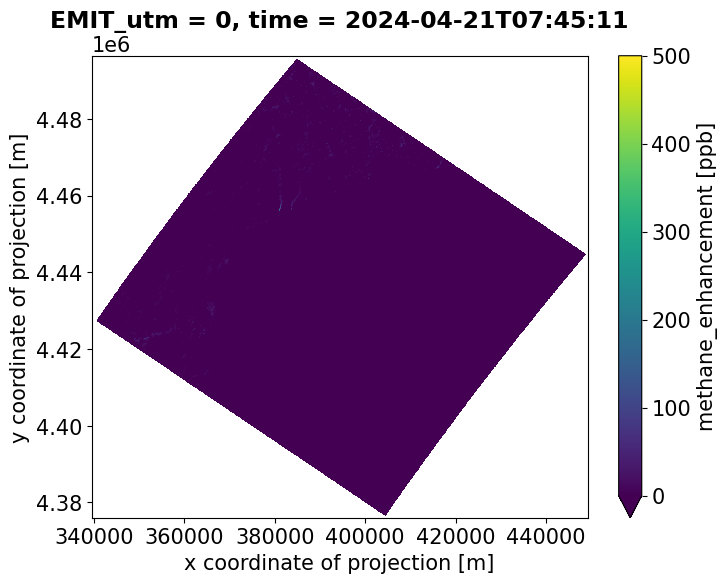

In [9]:
varname = 'ch4_comb_denoise'

thresholds, features, masks = get_feature_mask(ds_l2, varname=varname)
masks = masks.squeeze()

fig, axs = plt.subplots(figsize=(8, 6))
ds_l2[varname].plot(ax=axs, vmin=0, vmax=500)

# # Plot all features detected
# # for i, threshold in enumerate(thresholds):
# for i, threshold in enumerate(features['threshold_value'].astype('float').unique()):
#     thresholded_points = features[features['threshold_value'] == threshold]
#     axs.scatter(x=thresholded_points['projection_x_coordinate'].values,
#                 y=thresholded_points['projection_y_coordinate'].values,
#                 color='w',
#                 edgecolor='green',
#                 label='Detected features',
#                )

# plt.legend()
# fig.tight_layout()

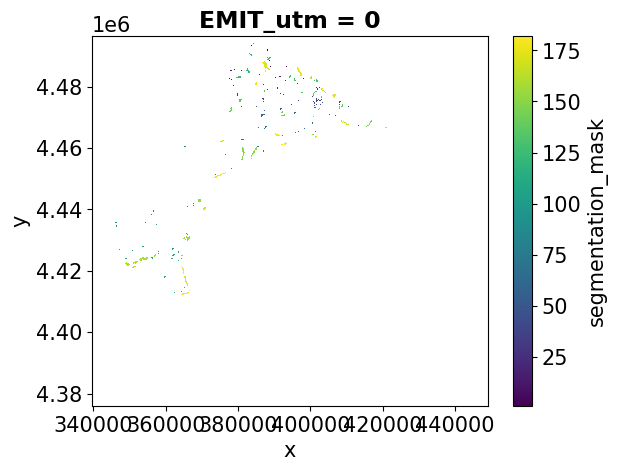

In [10]:
masks.where(masks>0).plot()

## Filter plume masks

In [11]:
# https://stackoverflow.com/a/66118219/7347925
def _azimuth(point1, point2):
    """azimuth between 2 points (interval 0 - 180)"""
    import numpy as np

    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180

def _dist(a, b):
    """distance between points"""
    import math

    return math.hypot(b[0] - a[0], b[1] - a[1])

def azimuth(mrr):
    """azimuth of minimum_rotated_rectangle"""
    bbox = list(mrr.exterior.coords)
    axis1 = _dist(bbox[0], bbox[3])
    axis2 = _dist(bbox[0], bbox[1])

    if axis1 <= axis2:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])

    return az

In [12]:
df_mask = masks.to_dataframe().reset_index()
df_mask = df_mask[df_mask['segmentation_mask']>0]
df_mask = df_mask[df_mask['segmentation_mask'].map(df_mask['segmentation_mask'].value_counts()).gt(5)]

gdf_point = gpd.GeoDataFrame(data=dict(segmentation_mask=df_mask['segmentation_mask'],
                                       geometry=gpd.points_from_xy(df_mask['x'], df_mask['y'])))
gdf_point = gdf_point.set_crs(f'epsg:{ds_l2.rio.crs.to_epsg()}')

gdf_polygon = gpd.GeoDataFrame(geometry=df_mask.groupby('segmentation_mask')\
                       .apply(lambda g: Polygon(gpd.points_from_xy(g['longitude'], g['latitude'])))
                      )
# gdf_polygon = gdf_polygon.set_crs(f'epsg:{ds_emit.rio.crs.to_epsg()}')

gdf_polygon['mrrs'] = gdf_polygon.geometry.apply(lambda geom: geom.minimum_rotated_rectangle)
gdf_polygon['az'] = gdf_polygon['mrrs'].apply(azimuth)

/tmp/ipykernel_781612/2770524210.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: Polygon(gpd.points_from_xy(g['longitude'], g['latitude'])))


In [13]:
center_map = [df_mask['latitude'].mean(), df_mask['longitude'].mean()]
m = folium.Map(location=center_map, zoom_start=12, tiles=None, control_scale=True)\

openstreet_tile = folium.TileLayer('OpenStreetMap')

esri_tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
)

# add tile
m.add_child(esri_tile)
# m.add_child(openstreet_tile)
Draw(export=True, position='topleft').add_to(m)

from folium.plugins import FeatureGroupSubGroup
fg = folium.FeatureGroup(name='test')
m.add_child(fg)
gplot = FeatureGroupSubGroup(fg, 'test')


for (index, row) in df_mask.iterrows():
                    folium.CircleMarker(location=[row.loc['latitude'], row.loc['longitude']], radius=3,
                                        color='dodgerblue', fill_color='dodgerblue', fill_opacity=0.3,
                                        popup='Mask label: '+str(row['segmentation_mask']),
                                        ).add_to(m)

# gdf_point.explore(popup=['segmentation_mask'])
# gdf_polygon.explore(m=m, popup=['segmentation_mask', 'az'])

In [14]:
# m

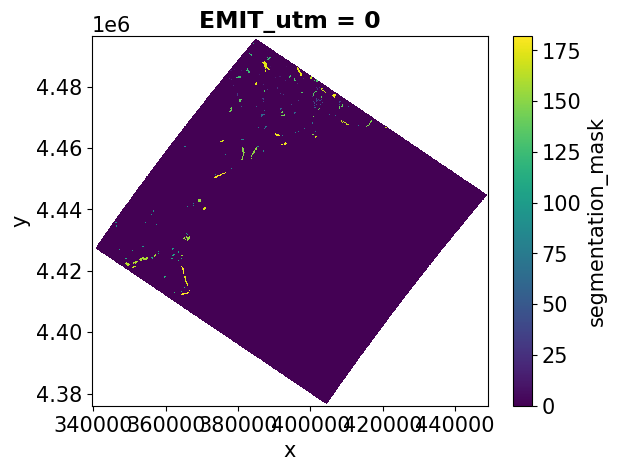

In [15]:
masks.plot()

In [16]:
struct = scipy.ndimage.generate_binary_structure(2, 2)
niter = int(180/dxy)
masks_dilation = masks.copy(deep=True, data=ndimage.binary_dilation(masks.fillna(0), iterations=niter, structure=struct))
# Label connected components in the dilated array
labeled_array, num_features = ndimage.label(masks_dilation)

masks_dilation = masks.copy(deep=True, data=labeled_array).where(masks.notnull())

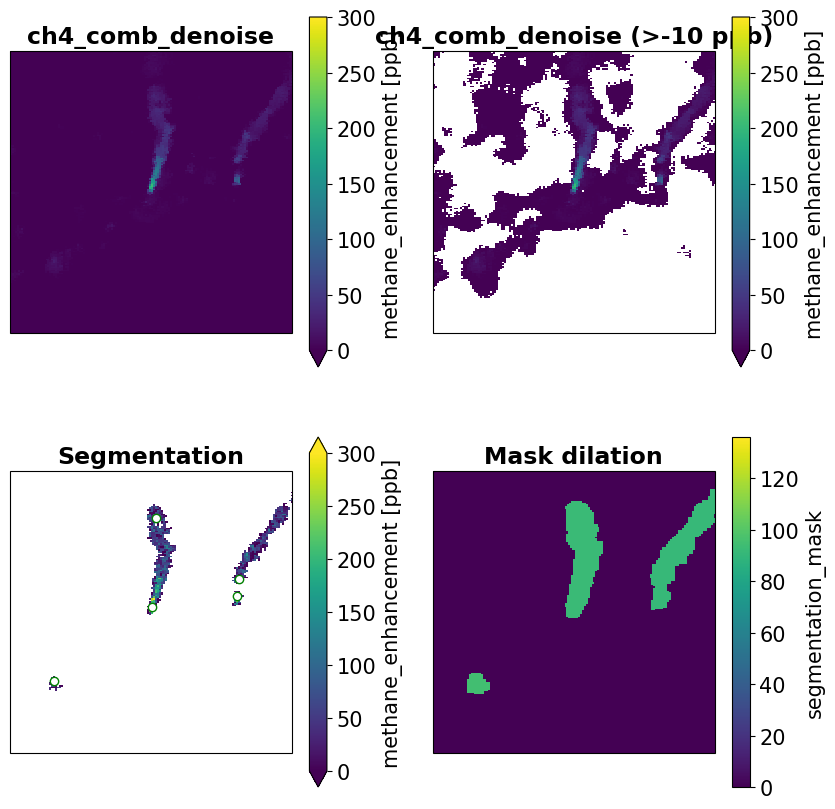

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()},)
axs = axs.flatten()

ds_l2[varname].plot(ax=axs[0], x='longitude', y='latitude',vmin=0, vmax=300)
axs[0].set_title(varname)

ds_l2[varname].where(ds_l2[varname]>thresholds[0]).plot(ax=axs[1], x='longitude', y='latitude',vmin=0, vmax=300)
axs[1].set_title(varname+f' (>{int(thresholds[0])} ppb)')

ds_l2['ch4'].where(masks).plot(ax=axs[2], x='longitude', y='latitude',vmin=0, vmax=300)
axs[2].set_title('Segmentation')

masks_dilation.plot(ax=axs[3], x='longitude', y='latitude')
axs[3].set_title('Mask dilation')

for i, threshold in enumerate(features['threshold_value'].astype('float').unique()):
    thresholded_points = features[features['threshold_value'] == threshold]
    axs[2].scatter(x=thresholded_points['longitude'].values,
                y=thresholded_points['latitude'].values,
                color='w',
                edgecolor='green',
                label='Detected features',
               )

# set extent
plume_longitude = 49.601544
plume_latitude = 40.246876
pad = 0.05

lon_min = plume_longitude - pad
lon_max = plume_longitude + pad
lat_min = plume_latitude - pad
lat_max = plume_latitude + pad
extent = (lon_min, lon_max, lat_min, lat_max)

for ax in axs:
    ax.set_extent(extent)  # Norte III

In [18]:
def get_index_nearest(lons, lats, lon_target, lat_target):
    # define the areas for data and source point
    area_source = SwathDefinition(lons=lons, lats=lats)
    area_target = SwathDefinition(lons=np.array([lon_target]), lats=np.array([lat_target]))

    # Determine nearest (w.r.t. great circle distance) neighbour in the grid.
    _, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
        source_geo_def=area_source, target_geo_def=area_target, radius_of_influence=50,
        neighbours=1)

    # get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
    y_target, x_target = np.unravel_index(index_array, area_source.shape)

    return y_target, x_target

In [19]:
def select_connect_masks(masks, y_target, x_target):
    # get the source label of original mask and dilation mask
    mask_target = masks[y_target, x_target].item()

    mask_dilation_target = masks_dilation[y_target, x_target].values
    # get the dilation mask which contains mask including the target
    mask_dilation_target = masks_dilation.where(masks_dilation==mask_dilation_target)

    # mask in the dilation mask
    masks_in_dilation = masks.where((masks>0)&(mask_dilation_target>0))
    
    # unique mask labels within the dilation mask
    connect_labels = np.unique(masks_in_dilation.data.flatten())

    # get the polygons inside the dilation mask which includes the target mask
    gdf_polygon_connect = gdf_polygon[gdf_polygon.index.isin(connect_labels)]
    
    # calculate polygon distance
    gdf_polygon_connect['distance'] = gdf_polygon_connect.geometry.apply(lambda g: gdf_polygon_connect[gdf_polygon_connect.index==mask_target]['geometry'].distance(g))
    # sort masks by distance
    gdf_polygon_connect.sort_values('distance', inplace=True)
    
    # calcualte differences of az
    gdf_polygon_connect.loc[:, 'az_diff'] = gdf_polygon_connect['az'].diff().abs().fillna(0)

    # # Drop rows where az_diff is higher than 30
    # for i in range(len(gdf_polygon_connect) - 1):
    #     if i >= len(gdf_polygon_connect)-1:
    #         break
    #     if gdf_polygon_connect['az_diff'].iloc[i+1] > 20:
    #         print(i+1, gdf_polygon_connect)
    #         gdf_polygon_connect = gdf_polygon_connect.drop(gdf_polygon_connect.index[i+1])
    #         gdf_polygon_connect['az_diff'] = gdf_polygon_connect['az'].diff().abs().fillna(0)

    index_name = gdf_polygon_connect.index.name
    gdf_polygon_connect = gdf_polygon_connect.reset_index()

    # Iterate through the DataFrame to drop rows where az_diff is higher than 30
    index = 0
    while index < len(gdf_polygon_connect) - 1:
        print(gdf_polygon_connect['az_diff'].iloc[index], gdf_polygon_connect['az_diff'].iloc[index + 1], gdf_polygon_connect['distance'].iloc[index + 1])
        # if (gdf_polygon_connect['az_diff'].iloc[index + 1] > 30) and (gdf_polygon_connect['distance'].iloc[index+1] > 0):
        if (gdf_polygon_connect['az_diff'].iloc[index + 1] > 180) and (gdf_polygon_connect['distance'].iloc[index+1] > 0):
            print('drop')
            gdf_polygon_connect = gdf_polygon_connect.drop(index + 1)
            gdf_polygon_connect = gdf_polygon_connect.reset_index(drop=True)
            gdf_polygon_connect['az_diff'] = gdf_polygon_connect['az'].diff().abs().fillna(0)
        else:
            index += 1

    # Set the index back to the original index values
    gdf_polygon_connect = gdf_polygon_connect.set_index(index_name)

    return gdf_polygon_connect, masks_in_dilation

In [20]:
y_target, x_target = get_index_nearest(ds_l2['longitude'], ds_l2['latitude'], plume_longitude, plume_latitude)


if masks[y_target, x_target] == 0:
    lon_mask = ds_l2['longitude'].where(ds_l2['ch4_mask']>0).data.flatten()
    lat_mask = ds_l2['latitude'].where(ds_l2['ch4_mask']>0).data.flatten()
    lon_mask = lon_mask[~np.isnan(lon_mask)]
    lat_mask = lat_mask[~np.isnan(lat_mask)]
    
    from shapely.geometry import Point
    min_index = gpd.points_from_xy(lon_mask, lat_mask).distance(Point(plume_longitude, plume_latitude)).argmin()
    y_target, x_target = get_index_nearest(ds_l2['longitude'], ds_l2['latitude'], lon_mask[min_index], lat_mask[min_index])

gdf_polygon_connect, masks_in_dilation = select_connect_masks(masks, y_target, x_target)

0.0 178.53856820254518 9.043140576204473e-09


/home/xinz/.local/share/mamba/envs/hypergas-mamba/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_781612/3169632779.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_polygon_connect.sort_values('distance', inplace=True)
/home/xinz/.local/share/mamba/envs/hypergas-mamba/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

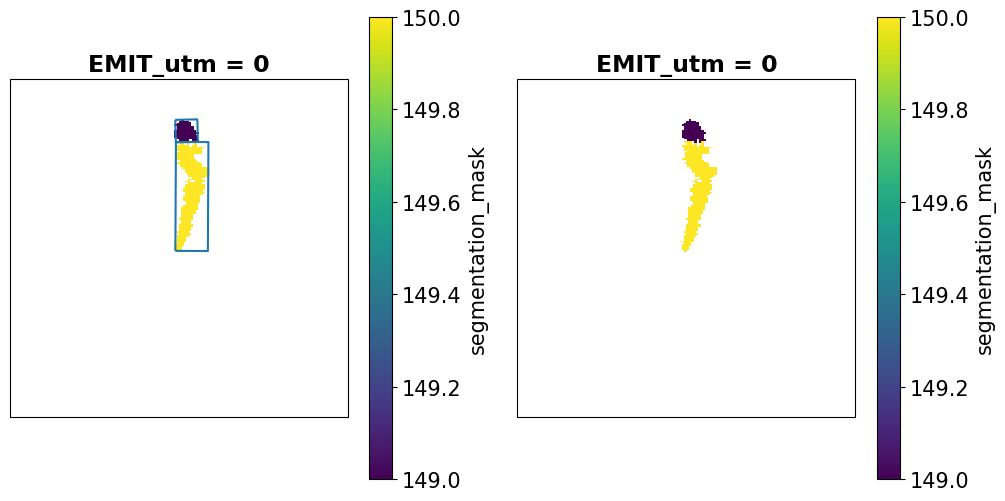

In [21]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))

ax = axs[0]
masks_in_dilation.plot(x='longitude', y='latitude', ax=ax)
gdf_polygon_connect['mrrs'].boundary.plot(ax=ax)

ax = axs[1]
connect_labels = gdf_polygon_connect.index
connect_masks = masks_in_dilation.where(masks_in_dilation.isin(connect_labels))
connect_masks.plot(ax=ax, x='longitude', y='latitude')

for ax in axs:
    ax.set_extent(extent)

In [22]:
def add_scalebar(ax, longitude, latitude, scale_bar_location='lower right'):
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(longitude-1, latitude),
                                  Point(longitude, latitude)],
                                 crs=4326)
    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=longitude,
            south_lat_degree=latitude,
            east_lon_degree=longitude,
            north_lat_degree=latitude,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)
    distance_meters = scale_points[0].distance(scale_points[1])
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='white',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )

    ax.add_artist(scalebar)

<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_781612/4072265008.py:51: SyntaxWarning: invalid escape sequence '\D'
  axs[0].set_title('Denoised $\Delta$XCH$_4$')


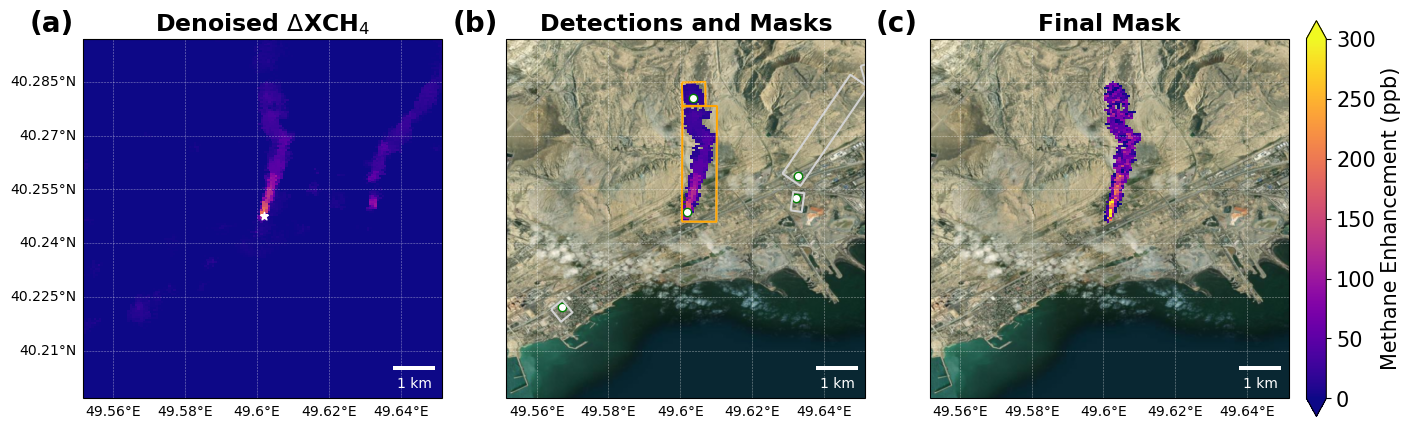

In [23]:
proj = ccrs.PlateCarree()

fig, axs = plt.subplots(nrows=1, ncols=3,
                        subplot_kw={'projection': proj},
                        figsize=(14, 8),
                        constrained_layout=True,
                        )
axs = axs.flatten()

for ax in axs:
    ax.set_extent(extent, crs=proj)


ds_l2['ch4_comb_denoise'].plot(ax=axs[0], vmin=0, vmax=300, cmap='plasma',
                     rasterized=True, x='longitude', y='latitude',
                     add_colorbar=False)#add_colorbar=False)#cbar_kwargs={'label': ''})

axs[0].scatter(49.6019294529485, 40.247695336521275, c='w', marker='*', zorder=100)

for ax in axs[1:]:
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove watermark
    ax.texts[0].remove()

ds_l2['ch4_comb_denoise'].where(~masks_in_dilation.isnull()).plot(x='longitude', y='latitude', ax=axs[1],
                                                                  vmin=0, vmax=300, cmap='plasma',
                                                                  rasterized=True,
                                                                  add_colorbar=False,
                                                                 )
gdf_polygon['mrrs'].boundary.plot(ax=axs[1], color='lightgray')
gdf_polygon_connect['mrrs'].boundary.plot(ax=axs[1], color='orange')


m = ds_l2['ch4'].where(~connect_masks.isnull()).plot(x='longitude', y='latitude', ax=axs[2],
                                                     vmin=0, vmax=300, cmap='plasma',
                                                     rasterized=True,
                                                     add_colorbar=True,
                                                     cbar_kwargs = {'shrink':0.5, 'label':'Methane Enhancement (ppb)'},
                                                    )

# Plot all features detected
for i, threshold in enumerate(features['threshold_value'].astype('float').unique()):
    thresholded_points = features[features['threshold_value'] == threshold]
    axs[1].scatter(x=thresholded_points['longitude'].values,
                y=thresholded_points['latitude'].values,
                color='w',
                edgecolor='green',
                label='Detected features',
               )

axs[0].set_title('Denoised $\Delta$XCH$_4$')
axs[1].set_title('Detections and Masks')
axs[2].set_title('Final Mask')

# fig.colorbar(m, ax=axs, extend='both', label='Methane Enhancement (ppb)', shrink=0.98)
    
for n, ax in enumerate(axs):
    ax.text(-0.15, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

for n, ax in enumerate(axs.flatten()):
    add_scalebar(ax, ds_l2['longitude'].mean(), ds_l2['latitude'].mean())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='w', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MaxNLocator(5)
    if n > 0:
        gl.left_labels = False

fig.savefig('../figures/plume_mask.pdf', bbox_inches='tight')